In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
  !cp -r '/content/drive/My Drive/mycode_dataset' '/subject101.dat'

#Importing library

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss

#Load data

In [4]:
def load_activity_map():
    map = {}
    map[0] = 'transient'
    map[1] = 'lying'
    map[2] = 'sitting'
    map[3] = 'standing'
    map[4] = 'walking'
    map[5] = 'running'
    map[6] = 'cycling'
    map[7] = 'Nordic_walking'
    map[9] = 'watching_TV'
    map[10] = 'computer_work'
    map[11] = 'car driving'
    map[12] = 'ascending_stairs'
    map[13] = 'descending_stairs'
    map[16] = 'vacuum_cleaning'
    map[17] = 'ironing'
    map[18] = 'folding_laundry'
    map[19] = 'house_cleaning'
    map[20] = 'playing_soccer'
    map[24] = 'rope_jumping'
    return map

In [5]:
def generate_three_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    return [x,y,z]

def generate_four_IMU(name):
    x = name +'_x'
    y = name +'_y'
    z = name +'_z'
    w = name +'_w'
    return [x,y,z,w]

def generate_cols_IMU(name):
    # temp
    temp = name+'_temperature'
    output = [temp]
    # acceleration 16
    acceleration16 = name+'_3D_acceleration_16'
    acceleration16 = generate_three_IMU(acceleration16)
    output.extend(acceleration16)
    # acceleration 6
    acceleration6 = name+'_3D_acceleration_6'
    acceleration6 = generate_three_IMU(acceleration6)
    output.extend(acceleration6)
    # gyroscope
    gyroscope = name+'_3D_gyroscope'
    gyroscope = generate_three_IMU(gyroscope)
    output.extend(gyroscope)
    # magnometer
    magnometer = name+'_3D_magnetometer'
    magnometer = generate_three_IMU(magnometer)
    output.extend(magnometer)
    # oreintation
    oreintation = name+'_4D_orientation'
    oreintation = generate_four_IMU(oreintation)
    output.extend(oreintation)
    return output

def load_IMU():
    output = ['time_stamp','activity_id', 'heart_rate']
    hand = 'hand'
    hand = generate_cols_IMU(hand)
    output.extend(hand)
    chest = 'chest'
    chest = generate_cols_IMU(chest)
    output.extend(chest)
    ankle = 'ankle'
    ankle = generate_cols_IMU(ankle)
    output.extend(ankle)
    return output
    
def load_subjects(root='/content/drive/My Drive/mycode_dataset' '/subject'):
    output = pd.DataFrame()
    cols = load_IMU()
    
    for i in range(101,109):
        path = root + str(i) +'.dat'
        subject = pd.read_table(path, header=None, sep='\s+')
        subject.columns = cols 
        subject['id'] = i
        output = output.append(subject, ignore_index=True)
    output.reset_index(drop=True, inplace=True)
    return output

data = load_subjects()

In [6]:
data

,time_stamp,activity_id,heart_rate,hand_temperature,hand_3D_acceleration_16_x,hand_3D_acceleration_16_y,hand_3D_acceleration_16_z,hand_3D_acceleration_6_x,hand_3D_acceleration_6_y,hand_3D_acceleration_6_z,hand_3D_gyroscope_x,hand_3D_gyroscope_y,hand_3D_gyroscope_z,hand_3D_magnetometer_x,hand_3D_magnetometer_y,hand_3D_magnetometer_z,hand_4D_orientation_x,hand_4D_orientation_y,hand_4D_orientation_z,hand_4D_orientation_w,chest_temperature,chest_3D_acceleration_16_x,chest_3D_acceleration_16_y,chest_3D_acceleration_16_z,chest_3D_acceleration_6_x,chest_3D_acceleration_6_y,chest_3D_acceleration_6_z,chest_3D_gyroscope_x,chest_3D_gyroscope_y,chest_3D_gyroscope_z,chest_3D_magnetometer_x,chest_3D_magnetometer_y,chest_3D_magnetometer_z,chest_4D_orientation_x,chest_4D_orientation_y,chest_4D_orientation_z,chest_4D_orientation_w,ankle_temperature,ankle_3D_acceleration_16_x,ankle_3D_acceleration_16_y,ankle_3D_acceleration_16_z,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,ankle_3D_magnetometer_x,ankle_3D_magnetometer_y,ankle_3D_magnetometer_z,ankle_4D_orientation_x,ankle_4D_orientation_y,ankle_4D_orientation_z,ankle_4D_orientation_w,id
0,8.38,0,104.0,30.0000,2.37223,8.60074,3.510480,2.43954,8.76165,3.354650,-0.092217,0.056812,-0.015845,14.6806,-69.2128,-5.58905,1.000000,0.000000,0.000000,0.000000,31.8125,0.238080,9.80003,-1.688960,0.265304,9.81549,-1.413440,-0.005065,-0.006781,-0.005663,0.471960,-51.0499,43.2903,1.000000,0.000000,0.000000,0.000000,30.3125,9.65918,-1.655690,-0.099797,9.64689,-1.555760,0.310404,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.000000,0.000000,0.000000,0.000000,101
1,8.39,0,NaN,30.0000,2.18837,8.56560,3.661790,2.39494,8.55081,3.642070,-0.024413,0.047758,0.006474,14.8991,-69.2224,-5.82311,1.000000,0.000000,0.000000,0.000000,31.8125,0.319530,9.61282,-1.493280,0.234939,9.78539,-1.428460,0.013685,0.001486,-0.041522,1.016900,-50.3966,43.1768,1.000000,0.000000,0.000000,0.000000,30.3125,9.69370,-1.579020,-0.215687,9.61670,-1.616300,0.280488,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.000000,0.000000,0.000000,0.000000,101
2,8.40,0,NaN,30.0000,2.37357,8.60107,3.548980,2.30514,8.53644,3.732800,-0.057976,0.032574,-0.006988,14.2420,-69.5197,-5.12442,1.000000,0.000000,0.000000,0.000000,31.8125,0.235593,9.72421,-1.766210,0.173850,9.72528,-1.518940,-0.039923,0.034056,-0.002113,0.383136,-51.8336,43.7782,1.000000,0.000000,0.000000,0.000000,30.3125,9.58944,-1.732760,0.092914,9.63173,-1.586050,0.280311,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.000000,0.000000,0.000000,0.000000,101
3,8.41,0,NaN,30.0000,2.07473,8.52853,3.660210,2.33528,8.53622,3.732770,-0.002352,0.032810,-0.003747,14.8908,-69.5439,-6.17367,1.000000,0.000000,0.000000,0.000000,31.8125,0.388697,9.53572,-1.724100,0.157969,9.64994,-1.579520,0.007513,-0.010498,-0.020684,0.315400,-49.8144,43.1670,1.000000,0.000000,0.000000,0.000000,30.3125,9.58814,-1.770400,0.054545,9.63197,-1.631350,0.340997,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.000000,0.000000,0.000000,0.000000,101
4,8.42,0,NaN,30.0000,2.22936,8.83122,3.700000,2.23055,8.59741,3.762950,0.012269,0.018305,-0.053325,15.5612,-68.8196,-6.28927,1.000000,0.000000,0.000000,0.000000,31.8125,0.315800,9.49908,-1.609140,0.233506,9.57411,-1.444180,-0.003822,-0.011217,-0.025975,-0.297733,-51.8097,43.6453,1.000000,0.000000,0.000000,0.000000,30.3125,9.69771,-1.656250,-0.060809,9.64699,-1.646470,0.340965,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.000000,0.000000,0.000000,0.000000,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864051,4086.15,0,NaN,30.8125,-9.54108,-2.02884,0.904692,-9.54984,-2.19390,0.884190,-0.027300,0.049635,-0.014393,43.7216,12.9255,-30.57730,0.032533,0.670927,0.111851,-0.732317,3

# Data pre processing

In [7]:
def fix_data(data):
    select = [4,5,7,12,13,24]
    #data = data.drop(data[data['activity_id']==0].index)
    data=data[data['activity_id'].isin(select)]
    data=data[['time_stamp','activity_id','ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y','ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z','id']]
    data = data.interpolate()
    # fill all the NaN values in a coulmn with the mean values of the column
    for colName in data.columns:
        data[colName] = data[colName].fillna(data[colName].mean())
    activity_mean = data.groupby(['activity_id']).mean().reset_index()
    return data

data = fix_data(data)

In [8]:
data

,time_stamp,activity_id,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
154281,1551.19,12,9.80851,-1.012340,-0.600316,-0.010195,-0.010306,-0.009147,101
154282,1551.20,12,9.73352,-1.027440,-0.569598,0.000103,-0.008209,-0.006737,101
154283,1551.21,12,9.77851,-1.072820,-0.584827,-0.003771,-0.024143,0.008858,101
154284,1551.22,12,9.77858,-1.042560,-0.569789,-0.009096,0.049125,0.004017,101
154285,1551.23,12,9.77875,-1.103000,-0.524190,-0.041132,0.005700,0.014554,101
...,...,...,...,...,...,...,...,...,...
2844273,3888.37,24,9.13521,-0.305301,-3.610920,0.119553,-0.046894,-0.102102,108
2844274,3888.38,24,9.10515,-0.169202,-3.626340,0.099501,-0.089781,-0.078137,108
2844275,3888.39,24,9.16531,-0.123796,-3.611670,0.086514,-0.041586,-0.096625,108
2844276,3888.40,24,9.21063,-0.123711,-3.551370,0.036153,-0.020759,-0.067416,108


#Data Explore

In [9]:
data['activity_id'].value_counts()

4     238761
7     188107
12    117216
13    104944
5      98199
24     42969
Name: activity_id, dtype: int64

In [10]:
data.describe()

,time_stamp,activity_id,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
count,790196.000000,790196.000000,790196.000000,790196.000000,790196.000000,790196.000000,790196.000000,790196.000000,790196.000000
mean,2583.508905,8.307949,11.603905,1.203796,-2.681451,-0.000611,-0.093932,0.009858,104.532245
std,648.653906,5.070546,7.608779,9.908152,4.638032,1.667152,0.949903,3.072677,2.348308
min,1461.210000,4.000000,-61.142000,-61.906400,-62.314800,-23.995000,-18.126900,-14.019600,101.000000
25%,2015.820000,4.000000,8.534425,-2.029620,-4.198783,-0.879629,-0.498911,-2.025410,102.000000
50%,2487.210000,7.000000,10.223900,0.182092,-2.406725,-0.088669,0.001698,-0.435700,105.000000
75%,3123.840000,12.000000,15.243000,3.439935,-0.866651,0.900797,0.394533,1.521303,107.000000
max,4245.680000,24.000000,61.969300,62.049000,60.935700,17.420400,13.588200,16.528800,108.000000


In [11]:
print('Size of the data: ', data.size)
print('Shape of the data: ', data.shape)
print('Number of columns in the data: ', len(data.columns))
#result_id = data.groupby(['id']).mean().reset_index()
#print('Number of unique ids in the data: ', len(result_id))
result_act = data.groupby(['activity_id']).mean().reset_index()
print('Numbe of unique activities in the data: ',len(result_act))


Size of the data:  7111764
Shape of the data:  (790196, 9)
Number of columns in the data:  9
Numbe of unique activities in the data:  6


In [12]:
def pd_fast_plot(pd,column_a,column_b,title, figsize=(10,6)):
    plt.rcParams.update({'font.size': 16})
    size = range(len(pd))
    f, ax = plt.subplots(figsize=figsize) 
    plt.bar(size, pd[column_a], color=plt.cm.Paired(size))
    a = ax.set_xticklabels(pd[column_b])
    b = ax.legend(fontsize = 20)
    c = ax.set_xticks(np.arange(len(pd)))
    d = ax.set_title(title)
    plt.show()

No handles with labels found to put in legend.


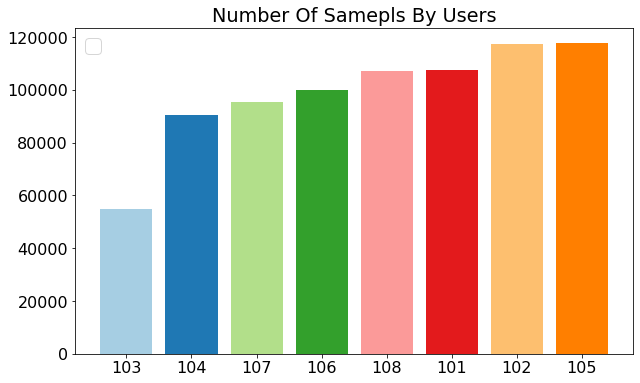

In [13]:
samples = data.groupby(['id']).count().reset_index()
samples_to_subject = pd.DataFrame()
samples_to_subject['id'] = samples['id']
samples_to_subject['samples'] = samples['time_stamp']
samples_to_subject = samples_to_subject.sort_values(by=['samples'])
pd_fast_plot(samples_to_subject,'samples','id','Number Of Samepls By Users')

No handles with labels found to put in legend.


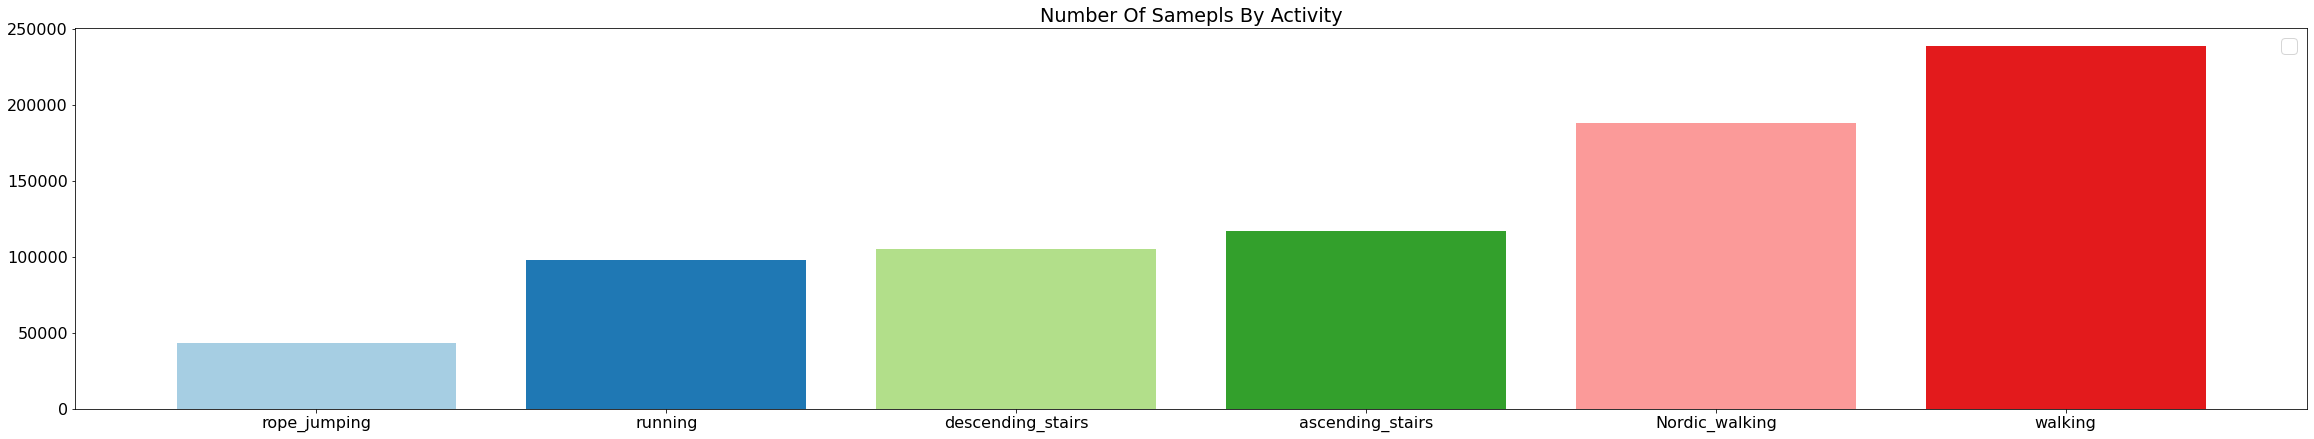

In [14]:
map_ac = load_activity_map()
samples = data.groupby(['activity_id']).count().reset_index()
samples_to_subject = pd.DataFrame()
samples_to_subject['activity'] = [map_ac[x] for x in samples['activity_id']]
samples_to_subject['samples'] = samples['time_stamp']
samples_to_subject = samples_to_subject.sort_values(by=['samples'])
pd_fast_plot(samples_to_subject,'samples','activity','Number Of Samepls By Activity',figsize=(40,7))

In [15]:
data['ankle_3D_acceleration_6_x'] = data['ankle_3D_acceleration_6_x'].astype('float')
data['ankle_3D_acceleration_6_y'] = data['ankle_3D_acceleration_6_y'].astype('float')
data['ankle_3D_acceleration_6_z'] = data['ankle_3D_acceleration_6_z'].astype('float')
data['ankle_3D_gyroscope_x'] = data['ankle_3D_gyroscope_x'].astype('float')
data['ankle_3D_gyroscope_y'] = data['ankle_3D_gyroscope_y'].astype('float')
data['ankle_3D_gyroscope_z'] = data['ankle_3D_gyroscope_z'].astype('float')

In [16]:
features = data[['ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y','ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z']]
label = data['activity_id']

In [17]:
data['activity_id'].value_counts()

4     238761
7     188107
12    117216
13    104944
5      98199
24     42969
Name: activity_id, dtype: int64

#Balancing dataset

In [18]:
Walking = data[data['activity_id']==4].head(42969).copy()
Jogging = data[data['activity_id']==5].head(42969).copy()
Upstairs = data[data['activity_id']==7].head(42969).copy()
Downstairs = data[data['activity_id']==12].head(42969).copy()
Sitting = data[data['activity_id']==13].head(42969).copy()
Standing = data[data['activity_id']==24].copy()

balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

(257814, 9)

In [19]:
balanced_data['activity_id'].value_counts()

24    42969
13    42969
12    42969
7     42969
5     42969
4     42969
Name: activity_id, dtype: int64

In [20]:
balanced_data.head()

,time_stamp,activity_id,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id
223759,2245.97,4,9.79575,-0.557960,-0.087112,-0.008637,-0.016637,0.010491,101
223760,2245.98,4,9.82616,-0.588092,0.003634,0.020660,-0.004149,-0.013735,101
223761,2245.99,4,9.84097,-0.663769,-0.041607,0.019979,0.000796,-0.009751,101
223762,2246.00,4,9.79605,-0.603242,-0.011292,0.014160,0.056483,0.009661,101
223763,2246.01,4,9.79613,-0.557849,0.003697,0.030738,-0.008582,-0.014538,101


#Standardization of data

In [21]:
label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity_id'])
balanced_data.head()

,time_stamp,activity_id,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,id,label
223759,2245.97,4,9.79575,-0.557960,-0.087112,-0.008637,-0.016637,0.010491,101,0
223760,2245.98,4,9.82616,-0.588092,0.003634,0.020660,-0.004149,-0.013735,101,0
223761,2245.99,4,9.84097,-0.663769,-0.041607,0.019979,0.000796,-0.009751,101,0
223762,2246.00,4,9.79605,-0.603242,-0.011292,0.014160,0.056483,0.009661,101,0
223763,2246.01,4,9.79613,-0.557849,0.003697,0.030738,-0.008582,-0.014538,101,0


In [22]:
features = balanced_data[['ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y','ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z']]
label = balanced_data['label']

In [23]:
scaler = StandardScaler()
X = scaler.fit_transform(features)

scaled_X = pd.DataFrame(data = X, columns = ['ankle_3D_acceleration_6_x','ankle_3D_acceleration_6_y','ankle_3D_acceleration_6_z','ankle_3D_gyroscope_x','ankle_3D_gyroscope_y','ankle_3D_gyroscope_z'])
scaled_X['label'] = label.values

scaled_X.head()

,ankle_3D_acceleration_6_x,ankle_3D_acceleration_6_y,ankle_3D_acceleration_6_z,ankle_3D_gyroscope_x,ankle_3D_gyroscope_y,ankle_3D_gyroscope_z,label
0,-0.204379,-0.215382,0.374877,0.008775,0.035862,-0.003432,0
1,-0.200644,-0.218358,0.393128,0.027144,0.048561,-0.011595,0
2,-0.198825,-0.225832,0.384029,0.026717,0.053591,-0.010252,0
3,-0.204342,-0.219855,0.390126,0.023069,0.110223,-0.003712,0
4,-0.204332,-0.215371,0.393140,0.033463,0.044053,-0.011865,0


#Frame Preparation

In [24]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [25]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 6

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        ax = df['ankle_3D_acceleration_6_x'].values[i: i + frame_size]
        ay = df['ankle_3D_acceleration_6_y'].values[i: i + frame_size]
        az = df['ankle_3D_acceleration_6_z'].values[i: i + frame_size]
        gx = df['ankle_3D_gyroscope_x'].values[i: i + frame_size]
        gy = df['ankle_3D_gyroscope_y'].values[i: i + frame_size]
        gz = df['ankle_3D_gyroscope_z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([ax, ay, az, gx, gy, gz])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((6444, 80, 6), (6444,))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [27]:
X_train.shape, X_test.shape

((5155, 80, 6), (1289, 80, 6))

In [28]:
X_train[0].shape, X_test[0].shape

((80, 6), (80, 6))

In [29]:
X_train = X_train.reshape(5155, 80, 6, 1)
X_test = X_test.reshape(1289, 80, 6, 1)

#2D CNN Model

In [30]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [49]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 200, validation_data= (X_test, y_test), verbose=1)

Epoch 1/200
162/162 [==============================] - 1s 5ms/step - loss: 0.1918 - accuracy: 0.9210 - val_loss: 0.5760 - val_accuracy: 0.8991
Epoch 2/200
162/162 [==============================] - 1s 3ms/step - loss: 0.1744 - accuracy: 0.9271 - val_loss: 0.6009 - val_accuracy: 0.8945
Epoch 3/200
162/162 [==============================] - 1s 3ms/step - loss: 0.1727 - accuracy: 0.9267 - val_loss: 0.5256 - val_accuracy: 0.8914
Epoch 4/200
162/162 [==============================] - 1s 3ms/step - loss: 0.1720 - accuracy: 0.9300 - val_loss: 0.6003 - val_accuracy: 0.8953
Epoch 5/200
162/162 [==============================] - 1s 3ms/step - loss: 0.1882 - accuracy: 0.9240 - val_loss: 0.6171 - val_accuracy: 0.8875
Epoch 6/200
162/162 [==============================] - 1s 3ms/step - loss: 0.1766 - accuracy: 0.9276 - val_loss: 0.5781 - val_accuracy: 0.8914
Epoch 7/200
162/162 [==============================] - 1s 4ms/step - loss: 0.1856 - accuracy: 0.9234 - val_loss: 0.5868 - val_accuracy: 0.8929

#Test accuracy and create confusion matrix

In [50]:
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [51]:
# Model Accuracy: how often is the classifier correct?
acc=metrics.accuracy_score(y_test, y_pred)
print("Accuracy:",round(acc*100,2))

Accuracy: 90.77


In [52]:
# Model Precision: what percentage of positive tuples are labeled as such?
p=metrics.precision_score(y_test, y_pred, average='macro')
r=metrics.recall_score(y_test, y_pred,  average='macro')
print("Precision:",round(p*100,2))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",round(r*100,2))

Precision: 90.94
Recall: 90.77


In [53]:
confusion_matrix(y_test, y_pred)

array([[194,   1,  11,   8,   1,   0],
       [  0, 204,   0,   9,   1,   1],
       [ 17,   0, 184,   8,   4,   2],
       [  8,   2,   8, 186,   9,   2],
       [  2,   0,   2,  10, 201,   0],
       [  0,   1,   1,   6,   5, 201]])

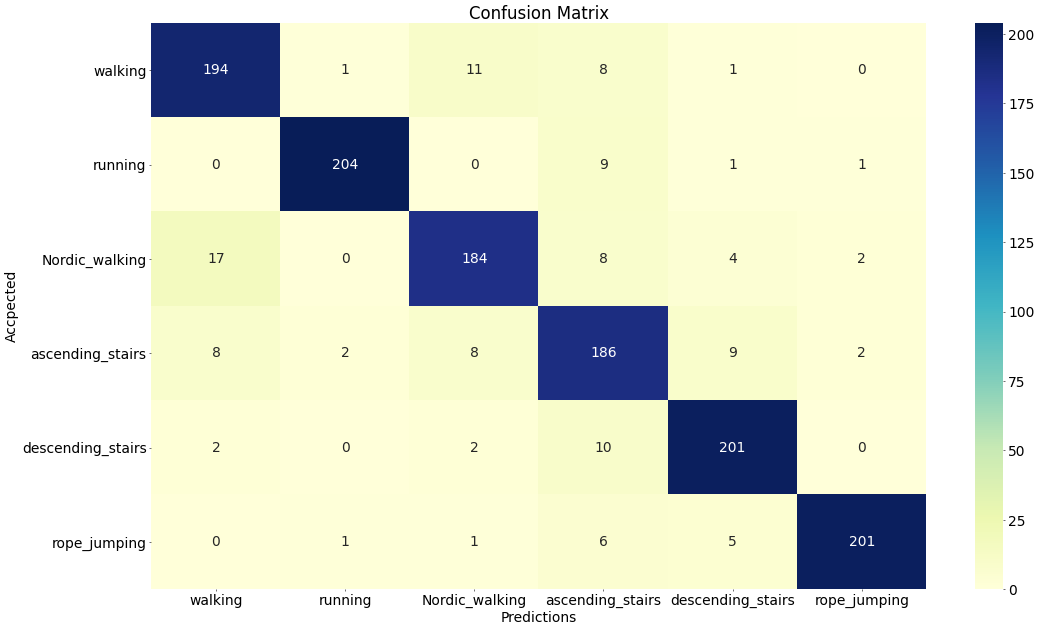

In [54]:
def quick_plot_con_matrix(y, results,labels):
    # now print confusion metrix
    con = confusion_matrix(y,results)
    a = plt.figure(figsize=(25,15), dpi=50)
    a = sns.heatmap(con, cmap='YlGnBu', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
    a = plt.rcParams.update({'font.size': 20})
    a = plt.title('Confusion Matrix')
    a = plt.xlabel('Predictions')
    a = plt.ylabel('Accpected')

#activity_map = load_activity_map()
labels = [map_ac[x] for x in samples['activity_id']]
quick_plot_con_matrix(y_test,y_pred, labels)